In [13]:
import thunderfish.dataloader as dl
import thunderfish.pulsetracker as pt
import thunderfish.eventdetection as ed
import matplotlib.pyplot as plt
import numpy as np
import os

In [14]:
# parameters for the analysis
thresh = 0.04 # minimal threshold for peakdetection
peakwidth = 20 # width of a peak and minimal distance between two EODs

In [15]:
def plot_peaks(x,y,peaksx,peaksy,c='k'):
    plt.figure(figsize=(10,5))
    plt.plot(x,y,zorder=-1)
    plt.scatter(starttime + peaksx/data.samplerate,peaksy,c=c)
    plt.xlabel('time [s]')
    plt.ylabel('signal')
    
def plot_events_on_data(peaks, data):
    """
        plots the detected events onto the data timeseries. If the events are classified, the classes are plotted in different colors and the class -1 (not belonging to a cluster) is plotted in black
    """
    plt.plot(range(len(data)),data, color = 'black')
    if len(peaks)>3:
        classlist =  np.array(peaks[3],dtype=np.int)
        if len(peaks) > 4:
            classlist = np.array(peaks[4],dtype=np.int)
        
        cmap = plt.get_cmap('jet')
        
        colors = cmap(np.linspace(0, 1.0, len(np.unique(classlist))))  #)) #len(np.unique(classlist))))
        
        #np.random.seed(1)
        #np.random.shuffle(colors)
    
        for cl, color in zip(np.unique(classlist), colors):
            if min(classlist) == 0 and cl == 0:
                color = 'black'
            if cl == -1:
                color = 'black'
            
            peaksofclass = peaks[:,classlist == cl]
            plt.plot(peaksofclass[0],peaksofclass[1], '.', color = color,   ms =20, label=cl)
    else:
        plt.scatter(peaks[0],peaks[1], color = 'red')
    plt.legend()
    #plt.show()
    
def cut_snippets(data,event_locations,cut_width,int_met="linear",int_fact=10,max_offset = 1000000): 
    """
    cuts intervals from a data array, interpolates and aligns them and returns them in a list

    TODO: ALIGN THEM TO CAUSE LEAST SQUARE ERROR

    Parameters
    ----------
    data: array

    event_locations: array

    cut_width: [int, int]
        lower and upper limit of the intervals relative to the event locations.
        f.e. [-15,15] indicates an interval of 30 datapoints around each event location
s
    int_met: string or int
        method of interpolation. (‘linear’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, ‘next’), or integer of order of spline interpolation to be used

    int_fact: int
        factor by which the interpolated array is larger than the original

    max_offset: float
        maximal offset by which the interpolated intervals can be moved to be aligned with each other. offset relative to the datapoints of the original data.

    Returns
    -------
    aligned_snips: twodimensional nparray
        the processed intervals (interval#,intervallen)

    """
    snippets = []
    cut_width = [-cut_width, cut_width]
    #alignwidth = int(np.ceil((max_offset) * int_fact))
    alignwidth = 100
    for pos in event_locations.astype('int'):
        snippets.append(data[pos+cut_width[0]:pos+cut_width[1]])
    ipoled_snips = np.empty((len(snippets), (cut_width[1]-cut_width[0])*int_fact-int_fact))
    
    for i, snip in enumerate(snippets):
        if len(snip) < ((cut_width[1]-cut_width[0])):
            if i == 0:
                snip = np.concatenate([np.zeros([((cut_width[1]-cut_width[0]) - len(snip))]),np.array(snip)])
            if i == len(snippets):
                snip = np.concatenate([snip, np.zeros([((cut_width[1]-cut_width[0])-len(snip))])])
            else:
                snip = np.zeros([(cut_width[1]-cut_width[0])])
       
         #f_interpoled = interpol(snip, int_met) #if len(snip) > 0 else np.zeros([(cut_width[1]-cut_width[0]-1)*int_fact ])
        interpoled_snip = pt.interpolated_array(snip, int_met, 10)#f_interpoled(np.arange(0, len(snip)-1, 1/int_fact))
        intsnipheight   = np.max(interpoled_snip) - np.min(interpoled_snip)
       
        if intsnipheight == 0:
            intsnipheight = 1
       
        interpoled_snip = (interpoled_snip - max(interpoled_snip))* 1/intsnipheight
        ipoled_snips[i] = interpoled_snip

    mean = np.mean(ipoled_snips, axis = 0)
    plt.plot(mean)
    aligned_snips = np.empty((len(snippets), (cut_width[1]-cut_width[0])* int_fact-(2*alignwidth)-int_fact))
    
    for i, interpoled_snip in enumerate(ipoled_snips):
        cc = pt.crosscorrelation(interpoled_snip[alignwidth:-alignwidth], mean)
        #cc = crosscorrelation(interpoled_snip[15 + 10*-cut_width[0]-10*7:-15+ -10*cut_width[1]+ 31], mean[10*-cut_width[0]-10*7:-10*cut_width[1]+31])
        offset = -alignwidth + np.argmax(cc)
        aligned_snip = interpoled_snip[alignwidth-offset:-alignwidth-offset] if offset != -alignwidth else interpoled_snip[2*alignwidth:]
        if len(aligned_snip[~np.isnan(aligned_snip)])>0:
            aligned_snips[i] = aligned_snip
    
    return aligned_snips, mean

def align_peak_classes(snips,labels):
    # try to align the means of all classes.
    # if the error is really low its probably the same class but shifted.
    
    means = np.zeros((len(np.unique(labels)),len(snips[0])))
    
    print(means.shape)
    
    for i,c in enumerate(np.unique(labels)):
        for j,c2 in enumerate(np.unique(labels)):
            
            print(np.max(pt.crosscorrelation(interpoled_snip[alignwidth:-alignwidth], mean)))
            
            print(np.mean(snips[labels==c],axis=0).shape)
            print(np.mean(snips[labels==c],axis=1).shape)
            means[i] = np.mean(snips[labels==c],axis=0)

    
    return means
    #aligned_snips = np.empty((len(snippets), (cut_width[1]-cut_width[0])* int_fact-(2*alignwidth)-int_fact))
        
    #for i, interpoled_snip in enumerate(ipoled_snips):
    #    cc = pt.crosscorrelation(interpoled_snip[alignwidth:-alignwidth], mean)

        #cc = crosscorrelation(interpoled_snip[15 + 10*-cut_width[0]-10*7:-15+ -10*cut_width[1]+ 31], mean[10*-cut_width[0]-10*7:-10*cut_width[1]+31])
    #    offset = -alignwidth + np.argmax(cc)
    #    aligned_snip = interpoled_snip[alignwidth-offset:-alignwidth-offset] if offset != -alignwidth else interpoled_snip[2*alignwidth:]
    #    if len(aligned_snip[~np.isnan(aligned_snip)])>0:
    #       aligned_snips[i] = aligned_snip

In [4]:
# create list of filepaths..
text_file = open("leticia_filenames_sorted.txt", "r")
lines = text_file.read().split('\n')
i = 36

In [5]:
filepath = '/home/dexter/' + lines[i][:-4] + '/' + lines[i]

In [6]:
filepath

'/home/dexter/70520L01_F10/70520L01_F10.WAV'

In [7]:
starttime = 0
endtime = 60   #in seconds

with dl.open_data(filepath, -1, 1.0) as data:
    dt = 1/data.samplerate
    # do something with the content of the file:
    x = np.arange(starttime,endtime,dt)
    y = data[starttime*data.samplerate:endtime*data.samplerate,0]

In [8]:
block1 = y[:int(len(y)/2)]
block2 = y[int(len(y)/2):]

block1x = x[:int(len(y)/2)]
block2x = x[int(len(y)/2):]

all_y = y

deltat = 30
nblock = int(deltat*data.samplerate)

In [9]:
y = block1
x = block1x

#thresh_array = pt.create_threshold_array(y,30000,thresh)
pk, tr = ed.detect_peaks(y, thresh)
peaks = pt.makeeventlist(pk,tr,y,peakwidth)
peakindices, peakx, peakh = pt.discardnearbyevents(peaks[0],peaks[1],peakwidth)
peaks = peaks[:,peakindices]

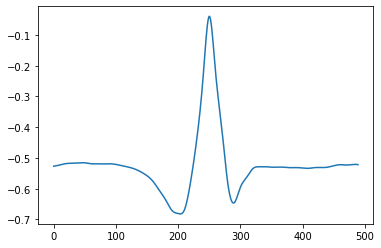

In [10]:
aligned_snips,mean = cut_snippets(y,peaks[0], 25, int_met = "cubic", int_fact = 10,max_offset = 10)

In [11]:
aligned_snips.shape

(2852, 290)

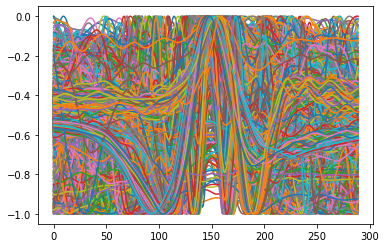

In [12]:
plt.plot(np.transpose(aligned_snips))
#plt.plot(mean,color='k')
plt.show()

# PCA method

In [13]:
pcs = pt.pc(aligned_snips)

order = 5  # this decided how many PC dimensions are used, 
           # could be improved by choosing this dynamically 
           # or by looking as scree plot

minpeaks = 10
labels = pt.cluster_events(pcs, peaks, order, 0.4, minpeaks, False, method = 'DBSCAN')
peaks = np.append(peaks,[labels], axis = 0)

TypeError: cluster_events() got multiple values for argument 'method'

In [ ]:
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(np.unique(labels))))  #)) #len(np.unique(classlist))))        

for i,eod in enumerate(aligned_snips):
    #if labels[i] in [0,3,4,5]:
        if labels[i] == -1:
            c = 'k'
            z=-1
        else:
            c=colors[labels[i]]
            z=1
        plt.plot(1000*np.arange(0,len(eod)/data.samplerate,1/data.samplerate),eod,color=c,zorder=z)
        plt.xlabel('time [ms]')
        plt.ylabel('signal')

In [ ]:
for i,eod in enumerate(pcs):
    #print(i)
    #if labels[i] in [0,3,4,5]:
        if labels[i] == -1:
            c = 'k'
            z = -1
        else:
            c=colors[labels[i]]
            z=1
        plt.plot(eod,color=c,zorder=z)
        plt.xlabel('time [ms]')
        plt.ylabel('signal')

In [ ]:
plot_events_on_data(peaks,y)

we dont care about the shape of the top of the waveform as it might be clipped. we do care about the sides of the waveform. If I find a basis function where I know which vars encode for the peak of the waveform, I can simply ignore that value when Im clustering the peaks.

# polinomial

In [ ]:
aligned_snips.shape

In [ ]:
npol = 20
p = np.zeros((len(aligned_snips),npol+1))
x = range(len(aligned_snips[0]))

for i,s in enumerate(aligned_snips):
    p[i] = np.polyfit(x,s,npol)

order = 20  # this decided how many PC dimensions are used, 
           # could be improved by choosing this dynamically 
           # or by looking as scree plot

minpeaks = 10

labels = pt.cluster_events(np.log(np.abs(p)), peaks, order, 0.1, minpeaks, False, method = 'DBSCAN')
peaks[3] = labels

In [ ]:
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(np.unique(labels))))  #)) #len(np.unique(classlist))))        

for i,eod in enumerate(aligned_snips):
    #if labels[i] in [0,3,4,5]:
        if labels[i] == -1:
            c = 'k'
            z=-1
        else:
            c=colors[labels[i]]
            z=1
        plt.plot(1000*np.arange(0,len(eod)/data.samplerate,1/data.samplerate),eod,color=c,zorder=z)
        plt.xlabel('time [ms]')
        plt.ylabel('signal')

In [ ]:
for i,eod in enumerate(p):
    #print(i)
    #if labels[i] in [0,3,4,5]:
        if labels[i] == -1:
            c = 'k'
            z = -1
        else:
            c=colors[labels[i]]
            z=1
        plt.plot(np.log(np.abs(eod)),color=c,zorder=z)
        plt.xlabel('time [ms]')
        plt.ylabel('signal')

In [ ]:
for i,eod in enumerate(aligned_snips):
    f = np.poly1d(p[i])
    plt.plot(f(x))

# chebyshev polynomial

In [14]:
a = np.polynomial.chebyshev.Chebyshev.fit(x,aligned_snips[0],10)

TypeError: expected x and y to have same length

In [16]:
npol = 5
p = np.zeros((len(aligned_snips),npol+1))
x = range(len(aligned_snips[0]))
funcs = []

for i,s in enumerate(aligned_snips):
    cheb = np.polynomial.chebyshev.Chebyshev.fit(x,s,npol)
    funcs.append(cheb)
    p[i] = cheb.coef

order = npol  # this decided how many PC dimensions are used, 
           # could be improved by choosing this dynamically 
           # or by looking as scree plot

minpeaks = 10

labels = pt.cluster_events(p, peaks, order, 0.015, minpeaks, False, method = 'DBSCAN')

try:
    peaks[3] = labels
except:
    peaks = np.append(peaks,[labels], axis = 0)

TypeError: cluster_events() got multiple values for argument 'method'

In [ ]:
%matplotlib inline
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(np.unique(labels))))  #)) #len(np.unique(classlist))))        

for i,eod in enumerate(aligned_snips):
    #if labels[i] in [1, 3]:
        if labels[i] == -1:
            c = 'k'
            z=-1
        else:
            c=colors[int(labels[i])]
            z=1
        plt.plot(1000*np.arange(0,len(eod)/data.samplerate,1/data.samplerate),eod,color=c,zorder=z)
        plt.xlabel('time [ms]')
        plt.ylabel('signal')

#plt.plot(1000*np.arange(0,len(mean)/data.samplerate,1/data.samplerate),mean,c='k')

In [ ]:
aligned_snips.shape

In [ ]:
plt.plot(np.transpose(means))

In [ ]:
for i,eod in enumerate(p):
    #print(i)
    #if labels[i] in [0,3,4,5]:
        if labels[i] == -1:
            c = 'k'
            z = -1
        else:
            c=colors[int(labels[i])]
            z=1
        plt.plot(eod,color=c,zorder=z)
        plt.xlabel('time [ms]')
        plt.ylabel('signal')

In [ ]:
for i,eod in enumerate(aligned_snips):
    if labels[i] == -1:
        c = 'k'
        z = -1
    else:
        c=colors[int(labels[i])]
        z=1
    f = funcs[i]
    plt.plot(f(x),c=c,zorder=z)

In [ ]:
np.unique(peaks[3])

In [ ]:
%matplotlib qt
plot_events_on_data(peaks,y)

# main code

In [ ]:
eods = pt.analyze_pulse_data(filepath, starttime=starttime, endtime=endtime ,save=False)

In [ ]:
np.unique(eods[4])

In [ ]:
%matplotlib qt
plot_events_on_data(eods,all_y)